In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import torch
from torch.utils.data import DataLoader
from torch.utils.data.dataset import TensorDataset
from models import KuraNet
from train import optimize_connectivity_net
from data import make_data, make_all_data, make_data2, get_BSDS_info
from utils import yield_zero_column, circular_variance, circular_moments, cohn_loss, make_masks
import os
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='0'

# Generate Data (Fix gain)

In [2]:
from os.path import expanduser
home = expanduser("~")
data_base_dir = os.path.join(home,'cluster_synchrony1')
if not os.path.exists(data_base_dir): os.makedirs(data_base_dir)

data_names=['BSDS']
dist_names = ['229036']

# Uncomment second and third lines if h and tau are not dirac distributions
# make_data2(data_names[0], dist_names[0], data_base_dir=data_base_dir, download=False)
# make_data(dist_names[1], data_base_dir=data_base_dir, num_samples=num_samples,notebook=True)
# make_data(dist_names[2], data_base_dir=data_base_dir, num_samples=num_samples,notebook=True)

# make_all_data(num_samples=args.num_samples,data_dir=args.data_dir)

# Set Training Parameters

In [8]:
seed=0
model_type='xy'
num_samples=10000
num_epochs=5
num_units=100
batch_size=100
feature_dim=5
num_hid_units=128
symmetric=False
normalize=False
device='cuda'
adjoint=False
solver_method='euler'
optimizer='Adam'
max_grad_norm=1.0
lr=2e-5
momentum=0.0
loss_type='circular_moments'
alpha=.1
gd_steps=100
burn_in_steps=50
measure_cx=False

num_batches = int(num_samples/num_units)

 # Set loss function
if loss_type == 'circular_variance':
    loss_func = circular_variance
elif loss_type == 'circular_moments':
    loss_func = circular_moments
elif loss_type == 'cohn_loss':
    loss_func = cohn_loss
else:
    raise Exception('Loss type not recognized.')
train_dls  = {}
test_dls   = {}

# Load training and testing data.
for dl, regime in zip([train_dls, test_dls], ['train', 'test']):
    for dist_name, data_name in zip(dist_names, data_names):
        if dist_name != 'degenerate':
            dt = np.load(os.path.join(data_base_dir, data_name, dist_name, regime, 'features.npz'))
            ds = TensorDataset(torch.FloatTensor(dt['x']), torch.LongTensor(dt['y'].astype(np.int32)))
        else:
            ds = TensorDataset(torch.zeros(num_samples).float(), torch.zeros(num_samples).long())
        dl[data_name] = DataLoader(ds, batch_size=num_units, shuffle=True, drop_last=True)
        
num_classes= len(set(dt['y']).union(set(dt['y'])))
data_keys = [key for key in train_dls.keys()]

# Run Training

In [6]:
np.random.seed(seed)
torch.manual_seed(seed)

loss_train, loss_test, kn, cx = optimize_connectivity_net(num_units, feature_dim, train_dls, test_dls, model_type=model_type,
                                                          num_classes=num_classes, avg_deg=1.0, normalize=normalize,
                                                          pretrained=False, num_epochs=num_epochs,  batch_size=num_units, 
                                                          burn_in_steps=burn_in_steps, gd_steps=gd_steps,
                                                          alpha=alpha, solver_method=solver_method, adjoint=adjoint,
                                                          loss_type=loss_type, optimizer=optimizer,
                                                          lr=lr, momentum=momentum, max_grad_norm=max_grad_norm,
                                                          num_hid_units=num_hid_units, verbose=1, show_every=10,
                                                          num_eval_batches=10, rand_inds=False, device=device)


Training. Epoch 0.
Training batch: 0. Time/Batch: 0.4434. Loss: 0.3636249601840973. Gradient norm: 1.0.
Training batch: 10. Time/Batch: 0.4205. Loss: 0.34592771530151367. Gradient norm: 1.0.
Training batch: 20. Time/Batch: 0.3907. Loss: 0.3862866163253784. Gradient norm: 1.0.
Training batch: 30. Time/Batch: 0.3882. Loss: 0.3121662735939026. Gradient norm: 1.0.
Training batch: 40. Time/Batch: 0.3677. Loss: 0.30219215154647827. Gradient norm: 0.3796448510028431.
Training batch: 50. Time/Batch: 0.3769. Loss: 0.22781409323215485. Gradient norm: 1.0.
Training batch: 60. Time/Batch: 0.3673. Loss: 0.26072901487350464. Gradient norm: 0.6191634089963322.
Training batch: 70. Time/Batch: 0.3619. Loss: 0.2335028350353241. Gradient norm: 0.6267226931518175.
Training batch: 80. Time/Batch: 0.3661. Loss: 0.2457553744316101. Gradient norm: 0.46313326820362244.
Training batch: 90. Time/Batch: 0.378. Loss: 0.24612116813659668. Gradient norm: 0.5481391722180805.
Training batch: 100. Time/Batch: 0.3757. L

Training batch: 40. Time/Batch: 0.3643. Loss: 0.2319316416978836. Gradient norm: 0.6255254574593714.
Training batch: 50. Time/Batch: 0.3659. Loss: 0.23041419684886932. Gradient norm: 0.6853465112607379.
Training batch: 60. Time/Batch: 0.3635. Loss: 0.17303970456123352. Gradient norm: 0.47564068738855686.
Training batch: 70. Time/Batch: 0.3665. Loss: 0.13162007927894592. Gradient norm: 0.24605967298606923.
Training batch: 80. Time/Batch: 0.3695. Loss: 0.22295986115932465. Gradient norm: 1.0.
Training batch: 90. Time/Batch: 0.3585. Loss: 0.19409064948558807. Gradient norm: 0.33705121617440065.
Training batch: 100. Time/Batch: 0.3491. Loss: 0.18365001678466797. Gradient norm: 0.7479431139134792.
Training batch: 110. Time/Batch: 0.3702. Loss: 0.20498068630695343. Gradient norm: 0.7756901720251114.
Training batch: 120. Time/Batch: 0.3749. Loss: 0.19236929714679718. Gradient norm: 1.0.
Training batch: 130. Time/Batch: 0.3615. Loss: 0.1519741714000702. Gradient norm: 0.4761006253692531.
Train

Training batch: 80. Time/Batch: 0.3684. Loss: 0.14024420082569122. Gradient norm: 0.2881027949557556.
Training batch: 90. Time/Batch: 0.3668. Loss: 0.12885355949401855. Gradient norm: 0.4281490097162988.
Training batch: 100. Time/Batch: 0.37. Loss: 0.12533266842365265. Gradient norm: 0.6341213866095109.
Training batch: 110. Time/Batch: 0.3651. Loss: 0.12934669852256775. Gradient norm: 0.6812261616563506.
Training batch: 120. Time/Batch: 0.3639. Loss: 0.1438220590353012. Gradient norm: 1.0.
Training batch: 130. Time/Batch: 0.3637. Loss: 0.15403233468532562. Gradient norm: 0.9130439727059182.
Training batch: 140. Time/Batch: 0.3758. Loss: 0.1867397576570511. Gradient norm: 0.6211814098506135.
Training batch: 150. Time/Batch: 0.3608. Loss: 0.1363334059715271. Gradient norm: 0.5531043322405672.
Training batch: 160. Time/Batch: 0.4121. Loss: 0.15921466052532196. Gradient norm: 1.0.
Training batch: 170. Time/Batch: 0.4045. Loss: 0.2550017237663269. Gradient norm: 1.0.
Training batch: 180. Ti

Training batch: 110. Time/Batch: 0.3631. Loss: 0.1191522553563118. Gradient norm: 0.732405334317171.
Training batch: 120. Time/Batch: 0.3647. Loss: 0.14142413437366486. Gradient norm: 0.5614476049573974.
Training batch: 130. Time/Batch: 0.37. Loss: 0.1996517926454544. Gradient norm: 0.21735522381079947.
Training batch: 140. Time/Batch: 0.3681. Loss: 0.10440271347761154. Gradient norm: 0.6957701365864345.
Training batch: 150. Time/Batch: 0.3671. Loss: 0.11560314148664474. Gradient norm: 0.7041617990974101.
Training batch: 160. Time/Batch: 0.3702. Loss: 0.11112464964389801. Gradient norm: 1.0.
Training batch: 170. Time/Batch: 0.3673. Loss: 0.07060343772172928. Gradient norm: 0.5109590102520463.
Training batch: 180. Time/Batch: 0.3708. Loss: 0.1325712949037552. Gradient norm: 0.5631641944522505.
Training batch: 190. Time/Batch: 0.3649. Loss: 0.07056862860918045. Gradient norm: 0.5683433191145356.
Training batch: 200. Time/Batch: 0.3702. Loss: 0.3404447138309479. Gradient norm: 1.0.
Traini

Training batch: 150. Time/Batch: 0.3676. Loss: 0.1027597039937973. Gradient norm: 0.8171747950848761.
Training batch: 160. Time/Batch: 0.3645. Loss: 0.07186120748519897. Gradient norm: 0.29540986822218096.
Training batch: 170. Time/Batch: 0.3666. Loss: 0.08998359739780426. Gradient norm: 0.3643767112198982.
Training batch: 180. Time/Batch: 0.3673. Loss: 0.10951360315084457. Gradient norm: 0.31920202320940555.
Training batch: 190. Time/Batch: 0.3602. Loss: 0.1319432109594345. Gradient norm: 0.24913851014669153.
Training batch: 200. Time/Batch: 0.3494. Loss: 0.1025700643658638. Gradient norm: 0.36339017116021965.
Training batch: 210. Time/Batch: 0.3603. Loss: 0.0797296017408371. Gradient norm: 0.34371280652037267.
Training batch: 220. Time/Batch: 0.3688. Loss: 0.20366759598255157. Gradient norm: 1.0.
Training batch: 230. Time/Batch: 0.3709. Loss: 0.09034696221351624. Gradient norm: 0.41802302367777894.
Training batch: 240. Time/Batch: 0.3704. Loss: 0.07684697210788727. Gradient norm: 0.5

# Visualization

Optimized loss: 0.0971


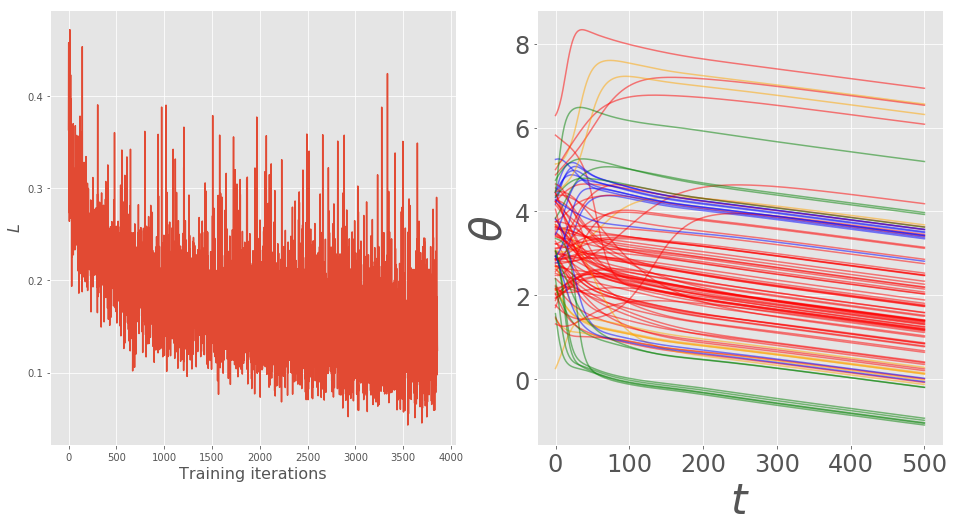

In [17]:
visualization_time=500

kn.set_grids(alpha, visualization_time, 1)

# Load one testing batch
for j, batch in enumerate(zip(*[test_dls[key] for key in data_keys])):
    X = {key : x.float().to(device) for (key, (x,_)) in zip(data_keys, batch)}
    Y = {key : y for (key, (_,y)) in zip(data_keys, batch)}
    # This is only used for cluster synchrony experiments
    if num_classes > 0:
        masks = make_masks(Y,num_classes,device)
    else:
        masks = None

    target = batch[0][1].numpy()
    # Fix max delay for memory problems
    if 'tau' in X.keys():
        X['tau']  = torch.where(X['tau'] > 40.0, 40.0 * torch.ones_like(X['tau']),X['tau'])
    break
    
# Sometimes animations look better if you increase the step size above that used during learning. 
kn.alpha= 15.0
# kn_control.alpha=1.0
flow = kn.run(X, full_trajectory=True)
print('Optimized loss: %.04f' % loss_func(flow[burn_in_steps:], masks=masks))

flow = flow.data.cpu().numpy() 

fig, axes = plt.subplots(1,2,figsize=(16,8))
all_colors = ['red', 'green', 'blue', 'orange', 'yellow', 'purple', 'pink', 'gray', 'black', 'magenta']

axes[0].plot(loss_train)
axes[0].set_xlabel('Training iterations', fontsize=16)
axes[0].set_ylabel(r'$L$', fontsize=16)

flow_colors = [all_colors[tg] for tg in target]

# flow = (flow % ((2 * np.pi) + 2 * np.pi)) % 2 * np.pi
# dflow = np.abs(np.concatenate((np.zeros((1,flow.shape[-1])), np.diff(flow,axis=0)), axis=0))
# flow = np.where(dflow > np.pi, np.nan, flow)
axes[1].set_prop_cycle('color', flow_colors)
axes[1].plot(flow, alpha=.5)
axes[1].set_xlabel(r'$t$',fontsize=42)
axes[1].set_ylabel(r'$\theta$',fontsize=42)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
# axes[1].set_ylim([0,2*np.pi])
# fig.tight_layout(pad=6)

plt.show()
plt.close()